In [16]:
# 1. Setup
import os
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [32]:
# 2. Parse annotations and collect face bounding boxes
def parse_xml(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    image_file = root.find('filename').text
    boxes = []
    for obj in root.findall('object'):
        label = obj.find('name').text
        bbox = obj.find('bndbox')
        box = {
            'label': label,
            'xmin': int(bbox.find('xmin').text),
            'ymin': int(bbox.find('ymin').text),
            'xmax': int(bbox.find('xmax').text),
            'ymax': int(bbox.find('ymax').text)
        }
        boxes.append(box)
    return image_file, boxes

base_path = "/kaggle/input/face-mask-detection"
annotations_path = os.path.join(base_path, "annotations")
images_path = os.path.join(base_path, "images")

data = []
for xml_file in os.listdir(annotations_path):
    file_path = os.path.join(annotations_path, xml_file)
    image_file, boxes = parse_xml(file_path)
    for box in boxes:
        data.append({
            "image_path": os.path.join(images_path, image_file),
            "label": box['label'],
            "bbox": (box['xmin'], box['ymin'], box['xmax'], box['ymax'])
        })

print("Total cropped faces:", len(data))


Total cropped faces: 4072


In [18]:
from collections import Counter

# Extract all labels from your dataset
labels = [item['label'] for item in data]

# Count occurrences
label_counts = Counter(labels)

# Print results
print("📊 Dataset Label Distribution:")
for label, count in label_counts.items():
    print(f"{label}: {count}")


📊 Dataset Label Distribution:
with_mask: 3232
mask_weared_incorrect: 123
without_mask: 717


In [19]:
label_map = {
    "with_mask": 0,
    "without_mask": 1,
    "mask_weared_incorrect": 2
}


In [20]:
class MaskFaceDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        image = Image.open(item["image_path"]).convert("RGB")
        xmin, ymin, xmax, ymax = item["bbox"]
        face = image.crop((xmin, ymin, xmax, ymax))
        if self.transform:
            face = self.transform(face)
        label = label_map[item["label"]]
        return face, label


In [21]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

train_data, val_data = train_test_split(data, test_size=0.2, stratify=[x['label'] for x in data], random_state=42)
train_dataset = MaskFaceDataset(train_data, transform=transform)
val_dataset = MaskFaceDataset(val_data, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

print(f"Train samples: {len(train_dataset)}, Validation samples: {len(val_dataset)}")


Train samples: 3257, Validation samples: 815


In [22]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 30 * 30, 128)
        self.fc2 = nn.Linear(128, 3)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # [32, 126, 126] -> [32, 63, 63]
        x = self.pool(F.relu(self.conv2(x)))  # [64, 61, 61] -> [64, 30, 30]
        x = x.view(-1, 64 * 30 * 30)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [23]:
model = CNNModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 5
for epoch in range(epochs):
    model.train()
    running_loss = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}")


Epoch 1/5, Loss: 0.2871
Epoch 2/5, Loss: 0.2036
Epoch 3/5, Loss: 0.1742
Epoch 4/5, Loss: 0.1558
Epoch 5/5, Loss: 0.1430


In [24]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()

print(f"Validation Accuracy: {100 * correct / total:.2f}%")


Validation Accuracy: 94.48%


In [26]:
torch.save(model.state_dict(), "mask_classifier.pth")
print("Model saved as mask_classifier.pth")


Model saved as mask_classifier.pth


🧠 Detected 1 face(s)


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128444 (\N{FRAME WITH PICTURE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


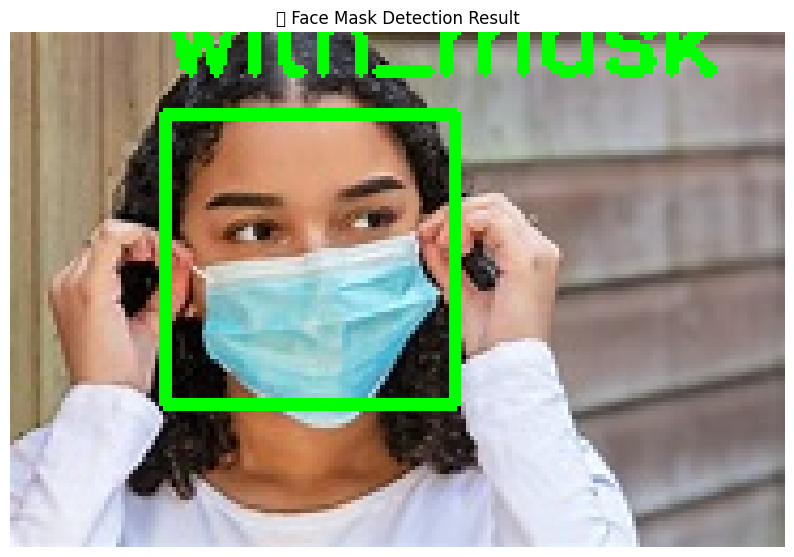

In [33]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont

# Load model
model = CNNModel()
model.load_state_dict(torch.load("mask_classifier.pth", map_location=torch.device('cpu')))
model.eval()
model.to(device)

# Label map
inv_label_map = {0: "with_mask", 1: "without_mask", 2: "mask_weared_incorrect"}
label_colors = {
    "with_mask": (0, 255, 0),
    "without_mask": (255, 0, 0),
    "mask_weared_incorrect": (0, 165, 255)
}

# Load image
img_path = "/kaggle/input/text-image-jpeg/text_image.jpeg"  # Uploaded image
original = cv2.imread(img_path)
if original is None:
    print("❌ Image not found or unreadable. Upload again.")
else:
    image = original.copy()
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Use OpenCV's Haar Cascade to detect faces
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)

    print(f"🧠 Detected {len(faces)} face(s)")

    for (x, y, w, h) in faces:
        face = image[y:y+h, x:x+w]
        face_rgb = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
        face_pil = Image.fromarray(face_rgb).resize((128, 128))
        
        transform = transforms.Compose([
            transforms.ToTensor()
        ])
        input_tensor = transform(face_pil).unsqueeze(0).to(device)

        with torch.no_grad():
            output = model(input_tensor)
            _, predicted = torch.max(output, 1)
            label = inv_label_map[predicted.item()]
            color = label_colors[label]

        # Draw bounding box
        cv2.rectangle(image, (x, y), (x+w, y+h), color, 2)
        cv2.putText(image, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2)

    # Show final image with predictions
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 8))
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.title("🖼️ Face Mask Detection Result")
    plt.show()
